In [1]:
# import standard modules and DCTR
import sys
import numpy as np
import math
import tensorflow as tf

# import DCTR
path_to_DCTR = '/tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/' # modify as needed
sys.path.append(path_to_DCTR)
import DCTR

# make sure GPU usage is enabled
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from importlib import reload
reload(DCTR)


<module 'DCTR' from '/tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/DCTR.py'>

# load data

In [4]:
# Load Datasets: MiNNLO: X1 | POWHEG hvq: X0
# all particles arrays

X0_test = []
# POWHEG hvq
# args: filePath, i=number of particles to load
X0_test = DCTR.load_dataset('/tf/data/BachelorThesis_Data/LHE/data/POWHEG_hvq/converted_lhe.npz', i=4)
print('POWHEG hvq X0_test.shape: '+str(X0_test.shape))

X1_test = []
# MiNNLO
X1_test = DCTR.load_dataset('/tf/data/BachelorThesis_Data/LHE/data/MiNNLO/converted_lhe.npz', i=4)
print('MiNNLO     X1_test.shape: '+str(X1_test.shape))


POWHEG hvq X0_test.shape: (29605180, 4, 9)
MiNNLO     X1_test.shape: (9553938, 4, 9)


In [5]:
# Load pre-normed Datasets: MiNNLO: X1 | POWHEG hvq: X0
# only contain tt-pair every event has order: 
# tt-pair, top, anti-top

# every particle has arguments: 
# [pt, rapidity, phi, mass, eta, E, PID, w, theta]
# [0 , 1       , 2  , 3   , 4  , 5, 6  , 7, 8    ]


X0_nrm = []
X1_nrm = []

# POWHEG hvq
X0_nrm = DCTR.load_dataset('/tf/data/BachelorThesis_Data/LHE/data/POWHEG_hvq/normed_lhe.npz')
print('POWHEG hvq all particles X0.shape: '+str(X0_nrm.shape))

# MiNNLO
X1_nrm = DCTR.load_dataset('/tf/data/BachelorThesis_Data/LHE/data/MiNNLO/normed_lhe.npz')
print('MiNNLO all particles X1.shape: '+str(X1_nrm.shape))


POWHEG hvq all particles X0.shape: (29605180, 3, 9)
MiNNLO all particles X1.shape: (9553938, 3, 9)


In [6]:
# get normalized event generator weights
X0_nrm_wgt = X0_nrm[:, 0, 7].copy()
X1_nrm_wgt = X1_nrm[:, 0, 7].copy()


In [7]:
# delete eta (pseudorpaidity) because neural network was too good at classifiying
X0_nrm = np.delete(X0_nrm, 4, -1)
X1_nrm = np.delete(X1_nrm, 4, -1)


# prep data for training

In [6]:
# prep arrays for the neural network

# prep_arrays() necessary args:
# X0, X1
# prep_arrays() default args:
# val=0.15, shuffle=True, use_class_weights=False

# strips theta parameter from datasets and creates Y classifier arrays
# strips wgts from datasets and creates wgt arrays | if use_class_weights==True: -> give over represented dataset smaller weights 
# splits arrays into training and validation datasets accroding to val
# splits arrays into training and validation datasets accroding to val

X_train, X_val, Y_train, Y_val, wgt_train, wgt_val = DCTR.prep_arrays(X0_nrm, X1_nrm, val=0.2)



# train DCTR neural network

In [8]:
# remove tt-pair from training: first index from second axis
# X_train, X_val, Y_train, Y_val, wgt_train, wgt_val = DCTR.prep_arrays(X0_nrm[:,1:,:], X1_nrm[:,1:,:], val=0.2)

dctr, callbacks = DCTR.setup_nn(input_dim=6, patience=15, saveLabel='DCTR_training_no_tt', loss='mse')
# DCTR.train(dctr, callbacks, X_train, Y_train, X_val, Y_val, wgt_train=wgt_train, wgt_val=wgt_val, epochs=200, batch_size=8192*32, saveLabel='DCTR_training_no_tt')
dctr.load_weights('DCTR_training_no_tt.h5')
with tf.device('/device:cpu:0'):
    weights_0_no_tt, _ = DCTR.predict_weights(dctr, X0_nrm[:,1:,:-2], X1_nrm[:,1:,:-2], batch_size=8192*16)


73/73 [==============================] - 9s 115ms/step


Epoch 1/200
119/120 [============================>.] - ETA: 0s - loss: 0.1652 - acc: 0.7538
Epoch 1: val_loss improved from inf to 0.15334, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/input_tests/DCTR_training_no_tt.h5
120/120 [==============================] - 14s 95ms/step - loss: 0.1651 - acc: 0.7538 - val_loss: 0.1533 - val_acc: 0.7560 - lr: 0.0010
Epoch 2/200
119/120 [============================>.] - ETA: 0s - loss: 0.1530 - acc: 0.7564
Epoch 2: val_loss improved from 0.15334 to 0.15267, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/input_tests/DCTR_training_no_tt.h5
120/120 [==============================] - 11s 90ms/step - loss: 0.1530 - acc: 0.7564 - val_loss: 0.1527 - val_acc: 0.7566 - lr: 0.0010
Epoch 3/200
119/120 [============================>.] - ETA: 0s - loss: 0.1525 - acc: 0.7572
Epoch 3: val_loss improved from 0.15267 to 0.15233, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Not

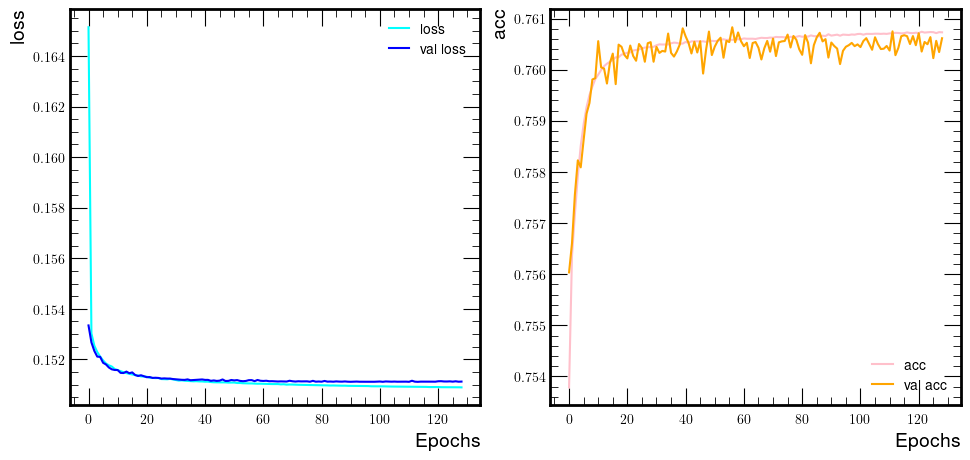

73/73 [==============================] - 11s 150ms/step


In [11]:
X_train, X_val, Y_train, Y_val, wgt_train, wgt_val = DCTR.prep_arrays(X0_nrm, X1_nrm, val=0.2)
# remove Energy from training: last index from last axis
with tf.device('/device:cpu:0'):
    X_train = tf.constant(X_train[:,:,:-1])
    X_val = tf.constant(X_val[:,:,:-1])

dctr, callbacks = DCTR.setup_nn(input_dim=5, patience=15, saveLabel='DCTR_training_no_E', loss='mse')
DCTR.train(dctr, callbacks, X_train, Y_train, X_val, Y_val, wgt_train=wgt_train, wgt_val=wgt_val, epochs=200, batch_size=8192*32, saveLabel='DCTR_training_no_E')

with tf.device('/device:cpu:0'):
    weights_0_no_E, _ = DCTR.predict_weights(dctr, X0_nrm[:,:,:-3], X1_nrm[:,:,:-3], batch_size=8192*16)


Epoch 1/200
119/120 [============================>.] - ETA: 0s - loss: 0.1591 - acc: 0.7551
Epoch 1: val_loss improved from inf to 0.15380, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/input_tests/DCTR_training_no_tt.h5
120/120 [==============================] - 10s 70ms/step - loss: 0.1591 - acc: 0.7551 - val_loss: 0.1538 - val_acc: 0.7560 - lr: 0.0010
Epoch 2/200
119/120 [============================>.] - ETA: 0s - loss: 0.1536 - acc: 0.7560
Epoch 2: val_loss improved from 0.15380 to 0.15328, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Notebooks/input_tests/DCTR_training_no_tt.h5
120/120 [==============================] - 8s 68ms/step - loss: 0.1536 - acc: 0.7560 - val_loss: 0.1533 - val_acc: 0.7560 - lr: 0.0010
Epoch 3/200
119/120 [============================>.] - ETA: 0s - loss: 0.1532 - acc: 0.7560
Epoch 3: val_loss improved from 0.15328 to 0.15315, saving model to /tf/home/gdrive/_STUDIUM_/Semester_06/BachelorThesis/Note

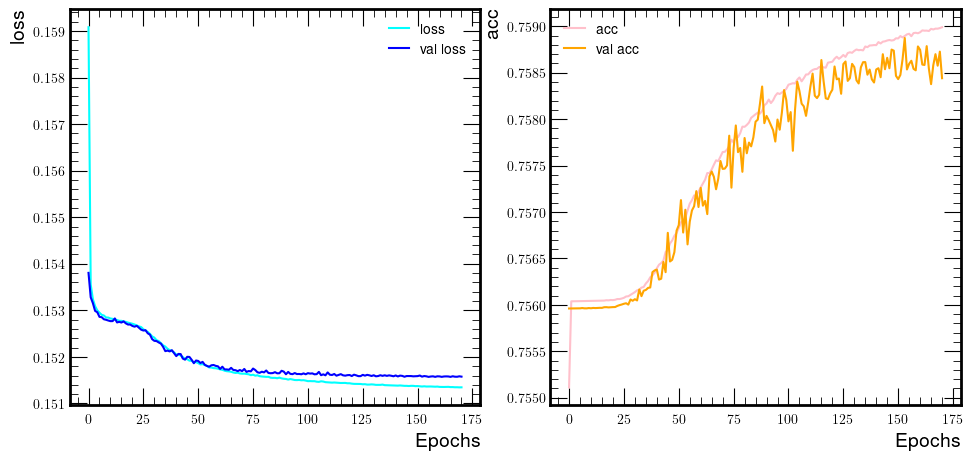

73/73 [==============================] - 9s 117ms/step


In [12]:
# remove Energy and tt-pair from training: first index from second axis and last index from last axis
X_train, X_val, Y_train, Y_val, wgt_train, wgt_val = DCTR.prep_arrays(X0_nrm, X1_nrm, val=0.2)
with tf.device('/device:cpu:0'):
    X_train = tf.constant(X_train[:,1:,:-1])
    X_val = tf.constant(X_val[:,1:,:-1])

dctr, callbacks = DCTR.setup_nn(input_dim=5, patience=15, saveLabel='DCTR_training_no_tt_E', loss='mse')
DCTR.train(dctr, callbacks, X_train, Y_train, X_val, Y_val, wgt_train=wgt_train, wgt_val=wgt_val, epochs=200, batch_size=8192*32, saveLabel='DCTR_training_no_tt_E')
with tf.device('/device:cpu:0'):
    weights_0_no_tt_E, _ = DCTR.predict_weights(dctr, X0_nrm[:,1:,:-3], X1_nrm[:,1:,:-3], batch_size=8192*16)


In [13]:
# current weights to compare to:
dctr, callbacks = DCTR.setup_nn(input_dim=6, loss='mse')
dctr.load_weights('DCTR_training.h5')
with tf.device('/device:cpu:0'):
    weights_0, _ = DCTR.predict_weights(dctr, X0_nrm[:,:,:-2], X1_nrm[:,:,:-2], batch_size=8192*16)


73/73 [==============================] - 11s 152ms/step


# load training and predict weights

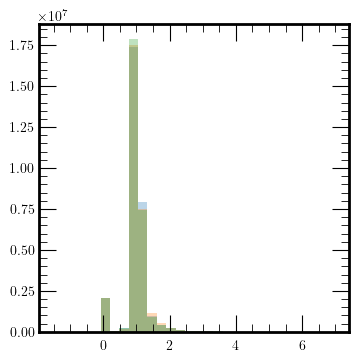

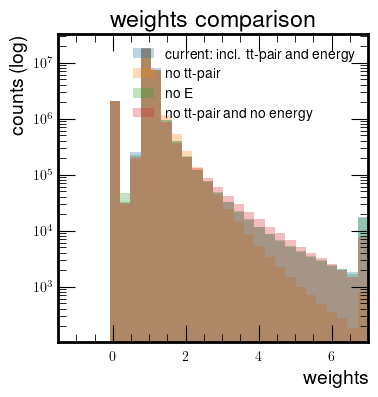

In [16]:
wgt_args = [(weights_0, 'current: incl. tt-pair and energy'),
            (weights_0_no_tt, 'no tt-pair'),
            (weights_0_no_E, 'no E'),
            (weights_0_no_tt_E, 'no tt-pair and no energy')]

DCTR.plot_weights(wgt_args, title='weights comparison', stop = 7)


# check and plot DCTR predictions

In [17]:
def delta_phi(X):
    phi_t = X[:,1, 2] # phi of top quark
    phi_t_bar = X[:,2, 2] # phi of anti-top quark
    delta = phi_t - phi_t_bar
    # remap delta from [-2*pi, 2*pi] to [0, 2pi]
    delta = ((delta + 2*math.pi) % (2*math.pi))
    # remap to [0, pi] since it is symmetrical
    delta = math.pi - abs(delta-math.pi)
    
    return delta

X0_delta_phi = delta_phi(X0_test)
X1_delta_phi = delta_phi(X1_test)

NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
current: incl. tt-pair and energy: 
 Mean Absolute Error 949.034375 
 chi square of 35.09405962859335 with p 0.20146776502010322 
 compared to NNLO
no tt-pair: 
 Mean Absolute Error 8683.20078125 
 chi square of 2118.241826701895 with p 0.0 
 compared to NNLO
no E: 
 Mean Absolute Error 1669.5716145833333 
 chi square of 59.294558333931946 with p 0.0007553547782811184 
 compared to NNLO
no tt-pair and no energy: 
 Mean Absolute Error 1118.152734375 
 chi square of 48.5033613561501 with p 0.013025330902701335 
 compared to NNLO


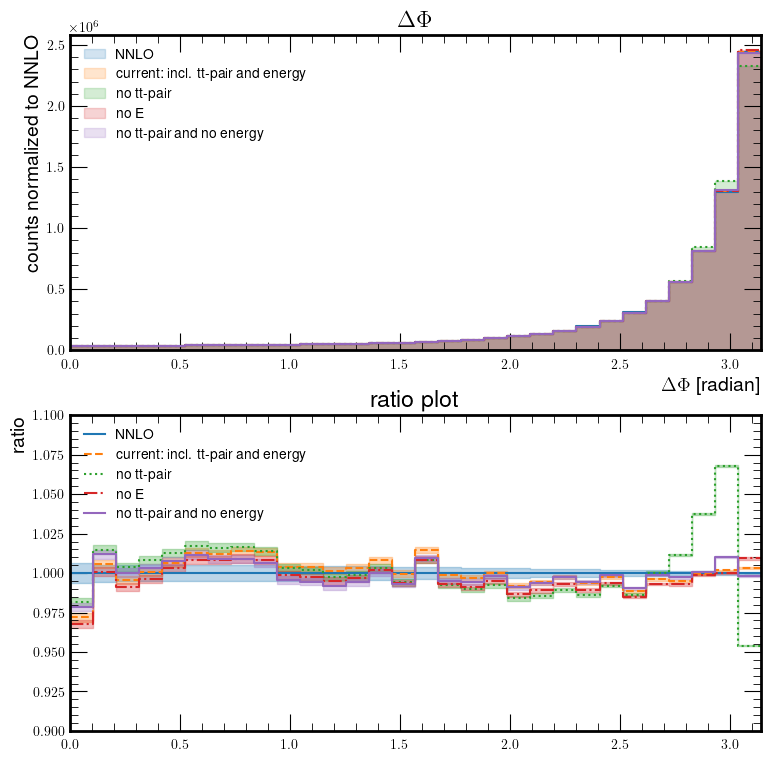

([0.0, 949.034375, 8683.20078125, 1669.5716145833333, 1118.152734375],
 [0.0,
  35.09405962859335,
  2118.241826701895,
  59.294558333931946,
  48.5033613561501],
 [1.0, 0.20146776502010322, 0.0, 0.0007553547782811184, 0.013025330902701335])

In [21]:
args_phi = [(X1_delta_phi, X1_nrm_wgt, 'NNLO'),
            (X0_delta_phi, weights_0, 'current: incl. tt-pair and energy'),
            (X0_delta_phi, weights_0_no_tt, 'no tt-pair'),
            (X0_delta_phi, weights_0_no_E, 'no E'),
            (X0_delta_phi, weights_0_no_tt_E, 'no tt-pair and no energy')]

DCTR.plot_ratio(args_phi, title = r'$\Delta \Phi$', x_label = r'$\Delta \Phi$ [radian]', start = 0, stop = math.pi, div = 31)


NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
current: incl. tt-pair and E: 
 Mean Absolute Error 708.7488423665365 
 chi square of 25.344234571803398 with p 0.6602682922107814 
 compared to NNLO
no tt-pair: 
 Mean Absolute Error 2712.0599197387696 
 chi square of 316.48265161853294 with p 4.390039396874534e-50 
 compared to NNLO
no E: 
 Mean Absolute Error 810.8831471761067 
 chi square of 28.269834315204758 with p 0.5035227446786776 
 compared to NNLO
no tt-pair and no E: 
 Mean Absolute Error 1050.8460372924806 
 chi square of 37.95403179918814 with p 0.12336186552165995 
 compared to NNLO


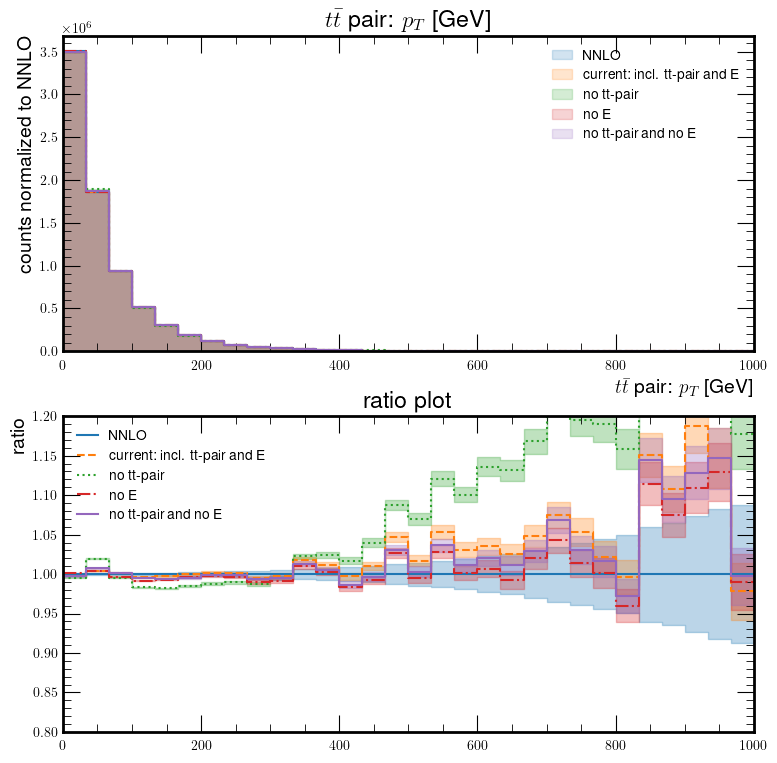

NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
current: incl. tt-pair and E: 
 Mean Absolute Error 1504.049252128601 
 chi square of 93.39276530962172 with p 1.0843489288286661e-08 
 compared to NNLO
no tt-pair: 
 Mean Absolute Error 1377.3063103993734 
 chi square of 82.3136303198113 with p 5.285002896103609e-07 
 compared to NNLO
no E: 
 Mean Absolute Error 948.275157292684 
 chi square of 30.55236042011274 with p 0.3868248267477651 
 compared to NNLO
no tt-pair and no E: 
 Mean Absolute Error 1443.3653419494628 
 chi square of 83.80751750075997 with p 3.167216985577434e-07 
 compared to NNLO


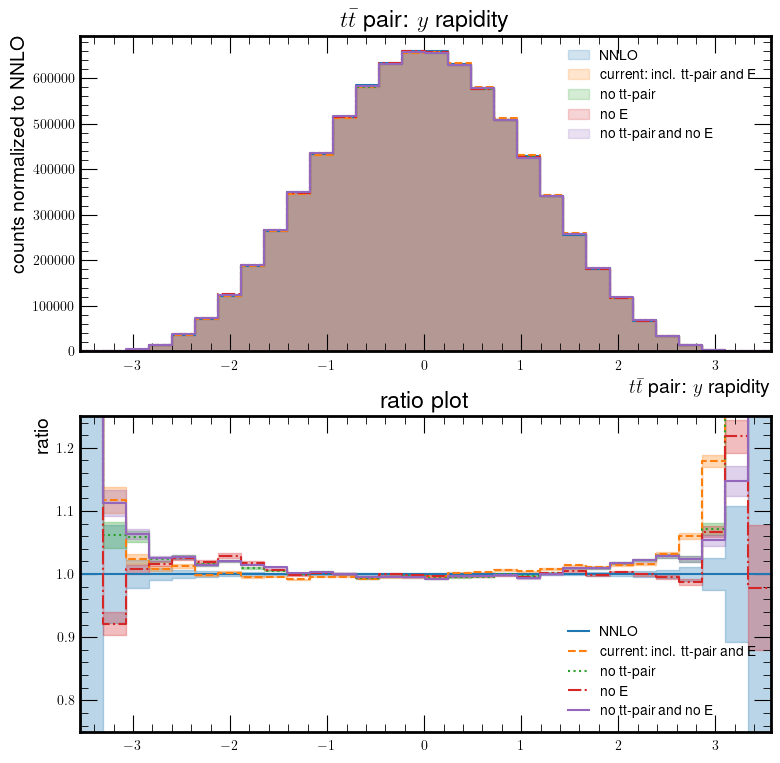

NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
current: incl. tt-pair and E: 
 Mean Absolute Error 607.8951985677083 
 chi square of 11.340559160055804 with p 0.9986506667865398 
 compared to NNLO
no tt-pair: 
 Mean Absolute Error 1019.7830973307292 
 chi square of 101.22130070629098 with p 6.232393932070798e-10 
 compared to NNLO
no E: 
 Mean Absolute Error 1450.6036458333333 
 chi square of 70.31006939317001 with p 2.749669628988683e-05 
 compared to NNLO
no tt-pair and no E: 
 Mean Absolute Error 1130.0556070963542 
 chi square of 106.47560012172111 with p 8.773305689872858e-11 
 compared to NNLO


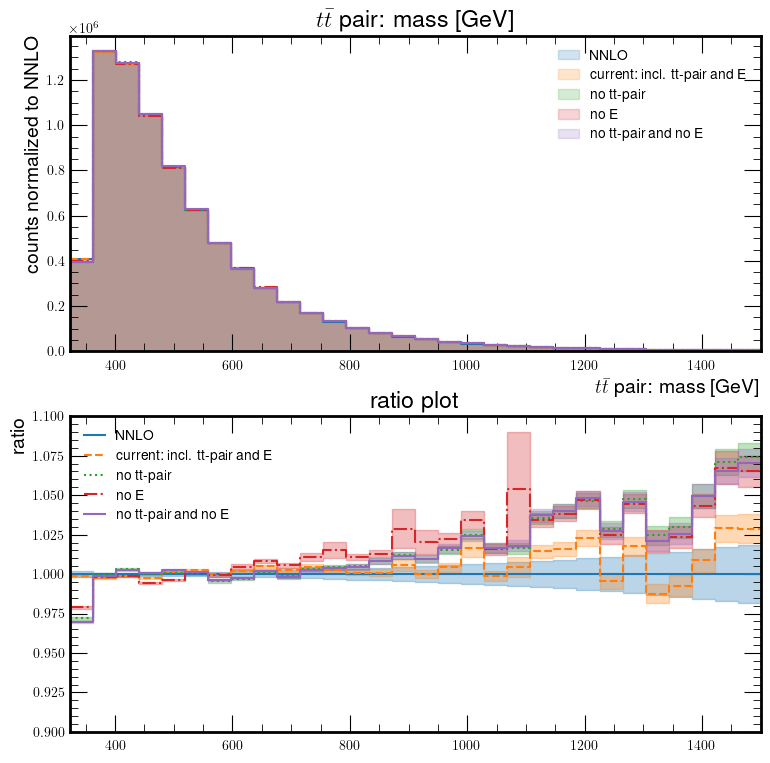

NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
current: incl. tt-pair and E: 
 Mean Absolute Error 1682.7936848958334 
 chi square of 98.95750507777782 with p 1.4355117294568062e-09 
 compared to NNLO
no tt-pair: 
 Mean Absolute Error 6734.2364501953125 
 chi square of 6716.010615296556 with p 0.0 
 compared to NNLO
no E: 
 Mean Absolute Error 1390.585819498698 
 chi square of 49.861356424232326 with p 0.009347283797357823 
 compared to NNLO
no tt-pair and no E: 
 Mean Absolute Error 3174.5623413085937 
 chi square of 2340.814733587607 with p 0.0 
 compared to NNLO


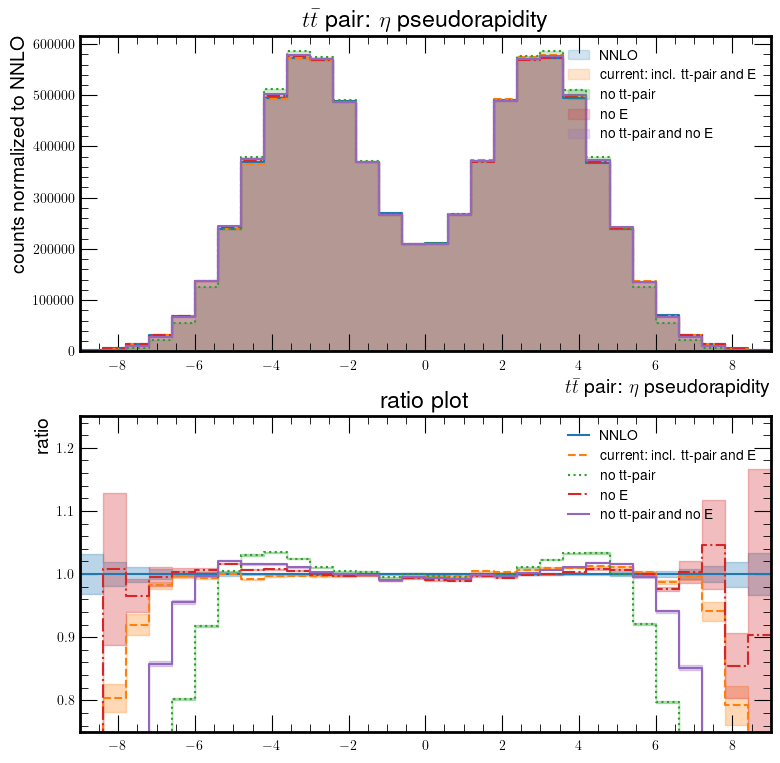

NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
current: incl. tt-pair and E: 
 Mean Absolute Error 932.2927083333333 
 chi square of 30.73916231068634 with p 0.37782301262588514 
 compared to NNLO
no tt-pair: 
 Mean Absolute Error 1941.3288411458334 
 chi square of 132.97640151612646 with p 2.9154068325334895e-15 
 compared to NNLO
no E: 
 Mean Absolute Error 1890.0310872395833 
 chi square of 68.89986112816219 with p 4.281681444752369e-05 
 compared to NNLO
no tt-pair and no E: 
 Mean Absolute Error 1882.6982096354166 
 chi square of 126.79934188994355 with p 3.406675883246722e-14 
 compared to NNLO


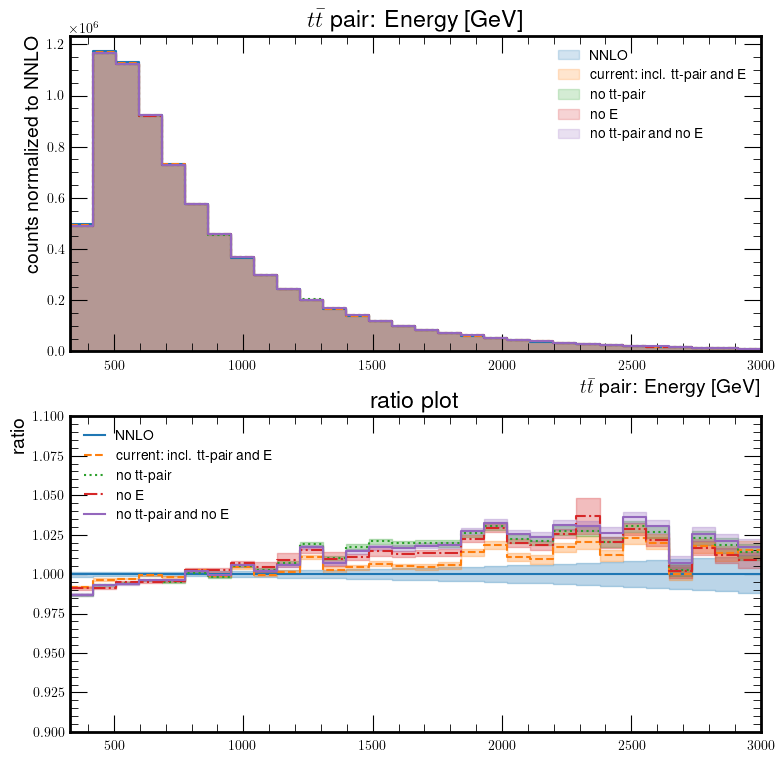

NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
current: incl. tt-pair and E: 
 Mean Absolute Error 592.2015833536784 
 chi square of 17.08921057070602 with p 0.9607776382419361 
 compared to NNLO
no tt-pair: 
 Mean Absolute Error 986.4408093770345 
 chi square of 73.32618431673582 with p 1.0492244712841529e-05 
 compared to NNLO
no E: 
 Mean Absolute Error 1059.332657623291 
 chi square of 34.02013284942724 with p 0.23852391319051908 
 compared to NNLO
no tt-pair and no E: 
 Mean Absolute Error 946.3315299987793 
 chi square of 64.93937477919476 with p 0.0001444349520017497 
 compared to NNLO


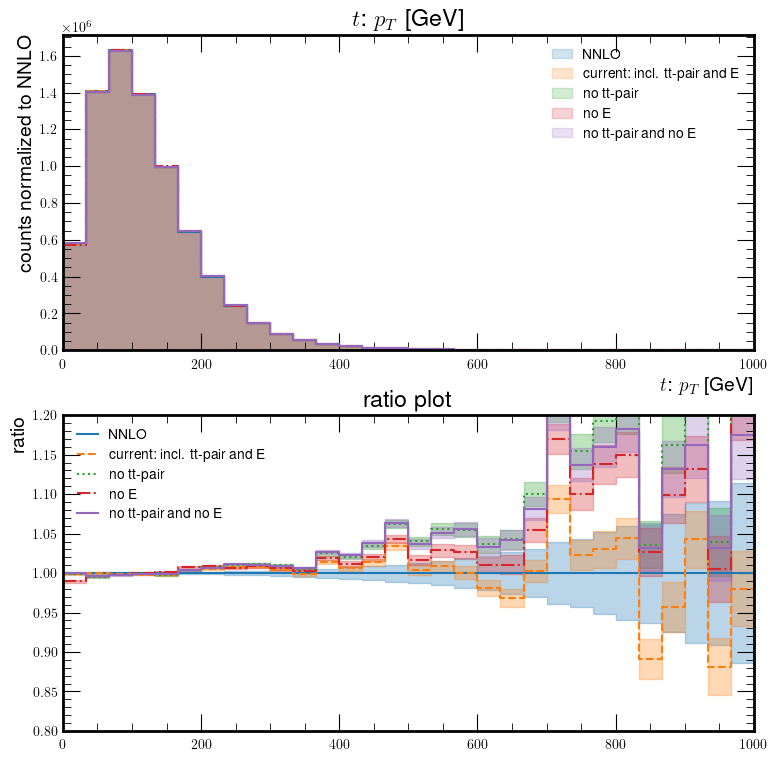

NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
current: incl. tt-pair and E: 
 Mean Absolute Error 1170.8744016965231 
 chi square of 66.8949378716975 with p 7.965867745160285e-05 
 compared to NNLO
no tt-pair: 
 Mean Absolute Error 1136.5837291876476 
 chi square of 75.33048760261298 with p 5.467480477246883e-06 
 compared to NNLO
no E: 
 Mean Absolute Error 1371.4862033367158 
 chi square of 45.05571782956128 with p 0.029059346707610772 
 compared to NNLO
no tt-pair and no E: 
 Mean Absolute Error 1120.4920504570007 
 chi square of 76.10833121883802 with p 4.23541681747335e-06 
 compared to NNLO


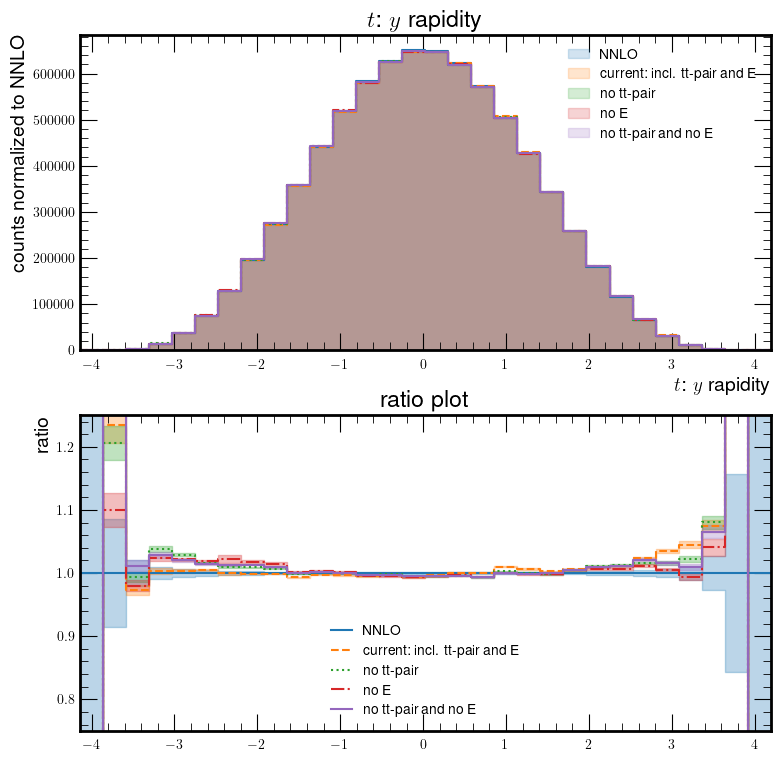

NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
current: incl. tt-pair and E: 
 Mean Absolute Error 575.8291015625 
 chi square of 57.837482308863954 with p 0.0016689769904934437 
 compared to NNLO
no tt-pair: 
 Mean Absolute Error 445.46033896169354 
 chi square of 38.165112457067565 with p 0.1455561158019494 
 compared to NNLO
no E: 
 Mean Absolute Error 574.4979838709677 
 chi square of 72.05272353813089 with p 2.5644422723646754e-05 
 compared to NNLO
no tt-pair and no E: 
 Mean Absolute Error 471.3592489919355 
 chi square of 25.941447572413487 with p 0.6781168535460395 
 compared to NNLO


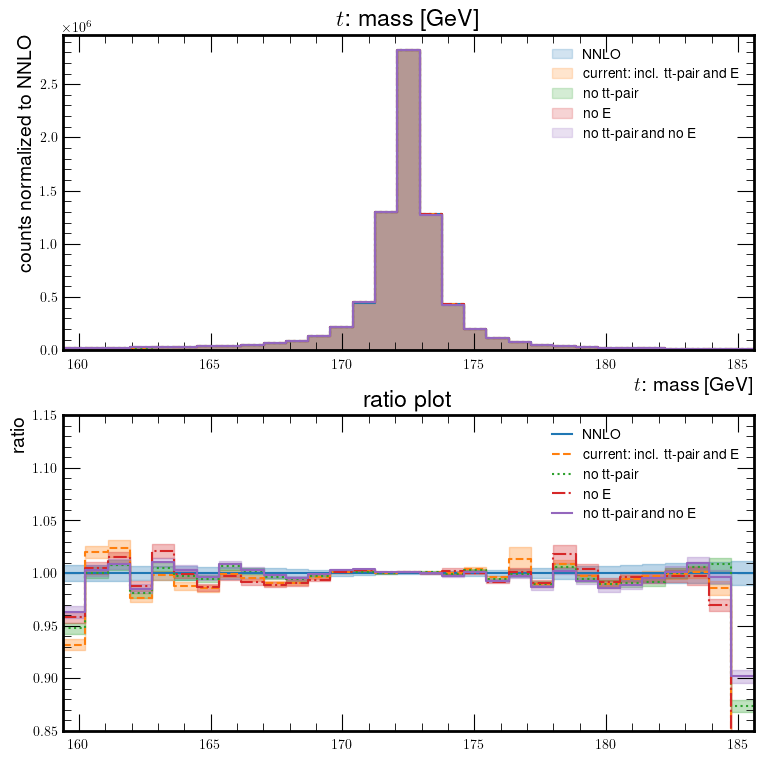

NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
current: incl. tt-pair and E: 
 Mean Absolute Error 1242.057284975052 
 chi square of 38.7994887453533 with p 0.10556395204709085 
 compared to NNLO
no tt-pair: 
 Mean Absolute Error 635.6213211377461 
 chi square of 18.159582209767493 with p 0.9409555318019367 
 compared to NNLO
no E: 
 Mean Absolute Error 901.7767575581869 
 chi square of 17.50982697464334 with p 0.9536571877835366 
 compared to NNLO
no tt-pair and no E: 
 Mean Absolute Error 730.5782944520314 
 chi square of 21.23776131104992 with p 0.8503413949654104 
 compared to NNLO


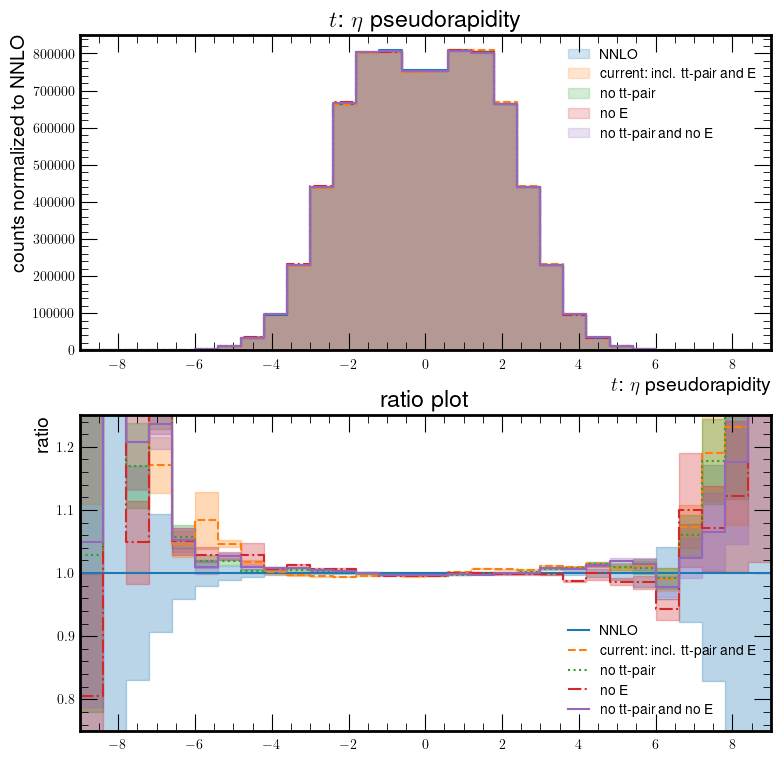

NNLO: 
 Mean Absolute Error 0.0 
 chi square of 0.0 with p 1.0 
 compared to NNLO
current: incl. tt-pair and E: 
 Mean Absolute Error 728.372802734375 
 chi square of 18.787135129363463 with p 0.9266245569632585 
 compared to NNLO
no tt-pair: 
 Mean Absolute Error 1320.1440755208334 
 chi square of 68.338904302041 with p 5.0993107476313186e-05 
 compared to NNLO
no E: 
 Mean Absolute Error 1530.1454264322917 
 chi square of 41.200733928034815 with p 0.0661353128935078 
 compared to NNLO
no tt-pair and no E: 
 Mean Absolute Error 1407.4684244791667 
 chi square of 69.03656641684601 with p 4.102655048837683e-05 
 compared to NNLO


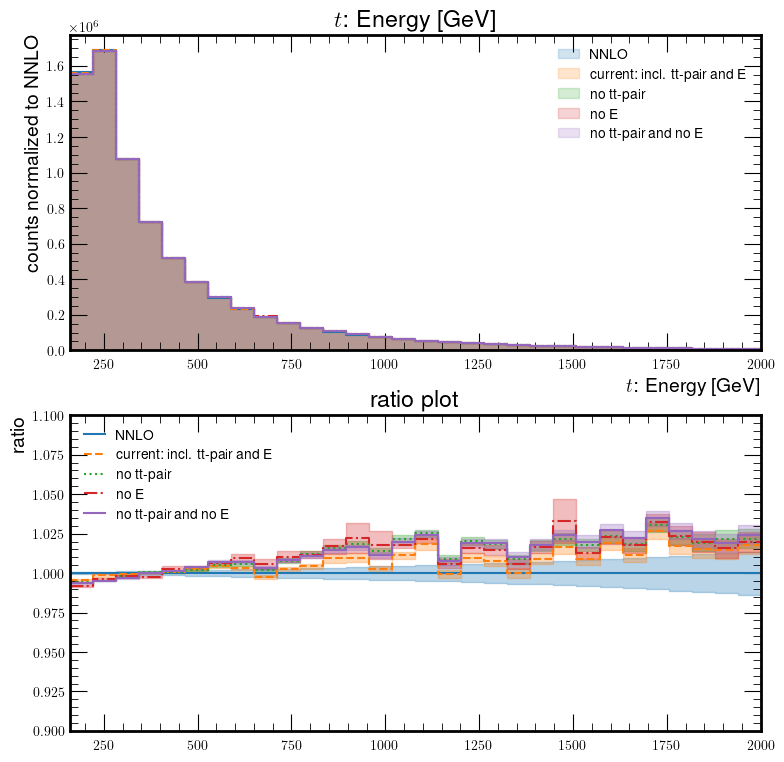

In [23]:
# DCTR.plot_ratio()
# takes args in form [(X0, wgt0, label0),(X1, wgt1, label1), etc.]
# plots histograms of X's and a ratio plot comapring all X's to X0 (first input in args)
# calculates, prints and returns mae, chi2 and p-value (from chi2 and num_bins)
# default parameters: 
    # arg_index = 0, part_index = 0, # which observable from the dataset to plot. Ignored if 1D dataset is passed (like in delta phi above)
    # title = None, x_label = None, y_label = None, # if None are given, generate title, etc. from arg/part index
    # bins = None, start = None, stop = None, div = 35, # if bins is None generate binning with start/stop if None are given use min/max
    # ratio_ylim=[0.9,1.1], figsize=(8,8), layout='rows', stats_only=False # plotting args

args = [(X1_test, X1_nrm_wgt, 'NNLO'),
        (X0_test, weights_0, 'current: incl. tt-pair and E'),
        (X0_test, weights_0_no_tt, 'no tt-pair'),
        (X0_test, weights_0_no_E, 'no E'),
        (X0_test, weights_0_no_tt_E, 'no tt-pair and no E')]

arg_indices = [0, 1, 3, 4, 5] # pt, y, eta, mass, energy
part_indices = [0, 1] # tt-pair and too

mae_all = []
chi2_all = []
p_all = []

# set plotting parameters
for part_index in part_indices:
    for arg_index in arg_indices:
        bins = []
        ratio_ylim = [0.75, 1.25]
        div = 31
        if arg_index == 1:  # rapidity
            start = None
            stop = None
        elif arg_index == 3:  # mass
            if part_index == 0:  # tt-pair
                start = None
                stop = 1500
                ratio_ylim = [0.90, 1.10]
            else:
                start = None
                stop = None
                div = 32
                ratio_ylim = [0.85, 1.15]
        elif arg_index == 4:  # pseudorapidity
            start = -9
            stop = 9
        elif arg_index == 5: # energy
            ratio_ylim = [0.9, 1.10]
            if part_index == 0:  # tt-pair
                start = None
                stop = 3000
            else:
                start = None
                stop = 2000
        else:  # pt
            ratio_ylim = [0.8, 1.2]
            start = 0
            stop = 1000
        
        # plot and calculate stats
        mae_list, chi2_list, p_list = DCTR.plot_ratio(args, arg_index=arg_index, part_index=part_index,
                                                      start=start, stop=stop, div=div, ratio_ylim=ratio_ylim)
        # save stats
        mae_all.append(mae_list)
        chi2_all.append(chi2_list)
        p_all.append(p_list)


In [24]:
# mean stats for each in args
mae_mean = np.mean(mae_all, axis = 0)
chi2_mean = np.mean(chi2_all, axis = 0)
p_mean = np.mean(p_all, axis = 0)

print('[NNLO], [current: incl. tt-pair and E], [no tt-pair], [no E], [no tt-pair and no E] \n')
print(f'MAE  mean: {mae_mean} \n')
print(f'chi2 mean: {chi2_mean} \n')
print(f'p    mean: {p_mean} \n')


[NNLO], [current: incl. tt-pair and E], [no tt-pair], [no E], [no tt-pair and no E] 

MAE  mean: [   0.          974.51148606 1830.8964893  1192.76178859 1335.77570857] 

chi2 mean: [  0.          45.91824811 762.23248703  45.77326168 295.31147062] 

p    mean: [1.         0.40314568 0.10865791 0.21871666 0.16520101] 

